<H1> Monocytes GWAS processing (DEPRECATED)

monocyte GWAS summary statistics obtained from https://ftp.sanger.ac.uk/pub/project/humgen/summary_statistics/UKBB_blood_cell_traits/<br> https://pmc.ncbi.nlm.nih.gov/articles/PMC7482360/#



In [1]:
# Imports
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
import heapq
import sys
sys.path.append("../Src")
from pathlib import Path
from magma_utils import run_gene_annotation, run_window_analysis, batch_gene_analysis
from file_handler import iterate_trait_files, create_run_dir
import subprocess as sp

result = sp.run(f"magma --version", shell=True, capture_output=True, text=True)
print(result.stdout) if result.stdout else None
print(result.stderr) if result.stderr else None

MAGMA version: v1.10 (linux/s)



In [2]:
# Data directories
GWAS_DIR = Path("../Data/GWAS")
SCDRS_DIR = Path("../Data/SCDRS")
MAGMA_DIR = Path("../Data/MAGMA")

mono_marker_genes = ["CTSS", "FCN1", "NEAT1", "LYZ", "PSAP", "S100A9", "AIF1", "MNDA", "SERPINA1", "TYROBP"]

# <b>1. Processing of GWAS summary statistics

In [ ]:
# Define traits 
TRAITS = {
    "mono_p": Path("path/to/data/Mono_perc_Leuk_GWAS.tsv.gz"),  # Percentage of white cells that are monocytes
    "mono_c": Path("path/to/data/Mono_count_GWAS.tsv.gz")  # Count of monocytes per unit volume of blood
}

print(f"Traits: {', '.join(TRAITS.keys())}")


Traits: mono_p, mono_c


In [4]:
# Read files
summ_stats = {}
for trait, file_path in TRAITS.items():
    print(f"Reading file {file_path}...")
    summ_stats[trait] = pd.read_csv(file_path, sep="\t", compression="gzip")
print("Done")

Reading file /groups/umcg-franke-scrna/tmp02/external_datasets/eqtlgen_parquet_dataset/gwas_id=Vuckovic_MONOCYTE_PERCENTAGE_OF_LEUKOCYTES/Mono_perc_Leuk_GWAS.tsv.gz...
Reading file /groups/umcg-franke-scrna/tmp02/external_datasets/eqtlgen_parquet_dataset/gwas_id=Vuckovic_MONOCYTE_COUNT/Mono_count_GWAS.tsv.gz...
Done


In [24]:
for trait, data in summ_stats.items():
    print(f"Total variants for {trait}: {len(data):,}")
    print(f"GWSIG variants(p < 5e-8): {(data['p'] < 5e-8).sum()}\n")
    print(data.head())
    print()

Total variants for mono_p: 9,270,230
GWSIG variants(p < 5e-8): 91109

      A1 A2      p        se       variant         bp  chromosome str_allele1  \
0  CAAAT  C  0.270  0.002160   rs139599623  100011685          10       CAAAT   
1     GA  G  0.032  0.002540  rs1223654463  100019534          10          GA   
2     CA  C  0.200  0.002285  rs1298198464  100027107          10          CA   
3     CA  C  0.340  0.002294  rs1167882806  100032091          10          CA   
4     CT  C  0.028  0.002349  rs1337637051  100040660          10          CT   

  str_allele2  variant_index      beta  
0           C       32021003  0.002390  
1           G       32021142 -0.005456  
2           C       32021321 -0.002959  
3           C       32021422 -0.002201  
4           C       32021570 -0.005163  

Total variants for mono_c: 8,893,396
GWSIG variants(p < 5e-8): 110359

    A1 A2     p        se             variant         bp  chromosome  \
0  TTA  T  0.75  0.003796          rs55663920  105564

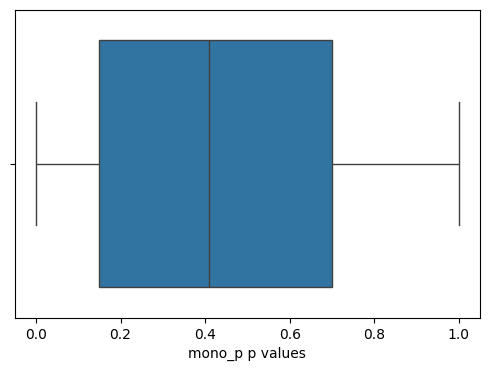

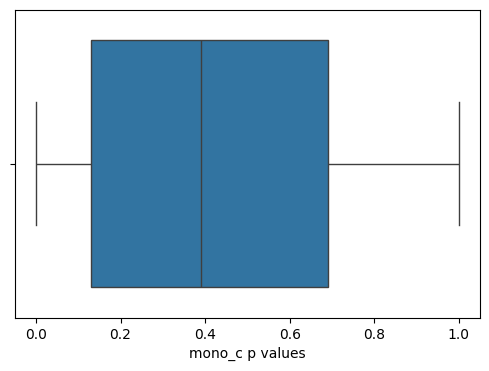

In [30]:
for trait, data in summ_stats.items():
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data['p'])

    # Add labels and title
    plt.xlabel(f"{trait} p values")

    # Show the plot
    plt.show()

In [32]:
# Effect size
for trait, data in summ_stats.items():
    print(trait)
    print(f"N SNPs with positive effect size: {len(data[data['beta'] > 0]):,}")
    print(f"N SNPs with negative effect size: {len(data[data['beta'] < 0]):,}")
    print(f"Minimum effect:{min(data['beta'])}, maximum effect:{max(data['beta'])}")
    print()

mono_p
N SNPs with positive effect size: 4,609,002
N SNPs with negative effect size: 4,661,228
Minimum effect:-0.199707, maximum effect:0.483355

mono_c
N SNPs with positive effect size: 4,428,673
N SNPs with negative effect size: 4,464,723
Minimum effect:-0.15134, maximum effect:0.555262



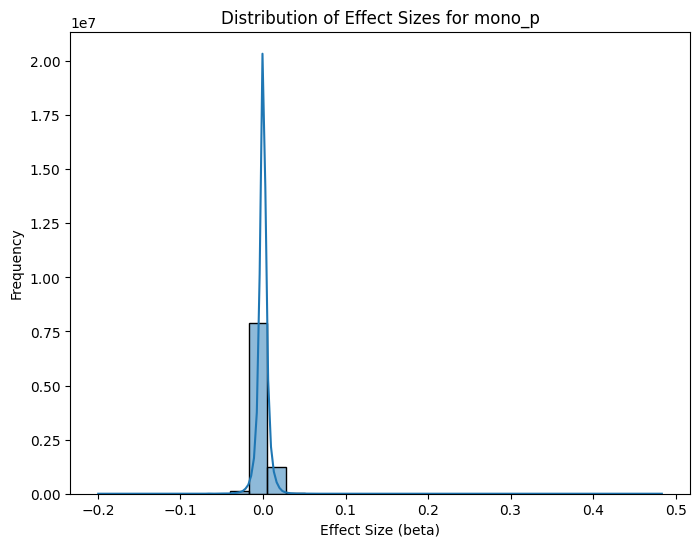

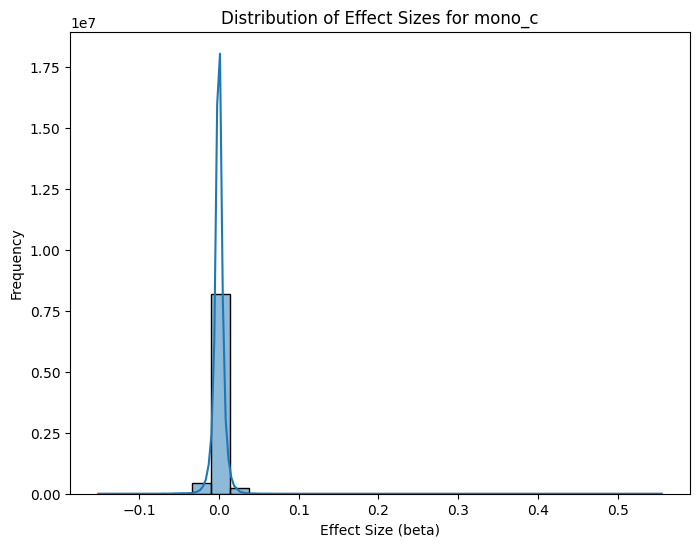

In [47]:
for trait, data in summ_stats.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(data['beta'], kde=True, bins=30)
    plt.title(f"Distribution of Effect Sizes for {trait}")
    plt.xlabel('Effect Size (beta)')
    plt.ylabel('Frequency')
    plt.show()


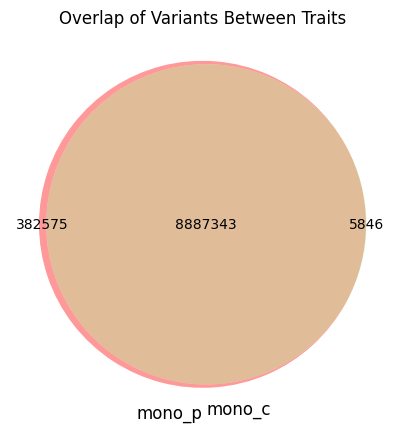

In [41]:
# Convert variant columns to sets
mono_p_variants = set(summ_stats["mono_p"]["variant"])
mono_c_variants = set(summ_stats["mono_c"]["variant"])

# Create Venn diagram
plt.figure(figsize=(5,5))
venn = venn2([mono_p_variants, mono_c_variants], set_labels=("mono_p", "mono_c"))
venn.get_patch_by_id('01').set_facecolor('#98FF98')

# Add a title
plt.title("Overlap of Variants Between Traits")

# Show the plot
plt.show()

Aligned variants: 8887605


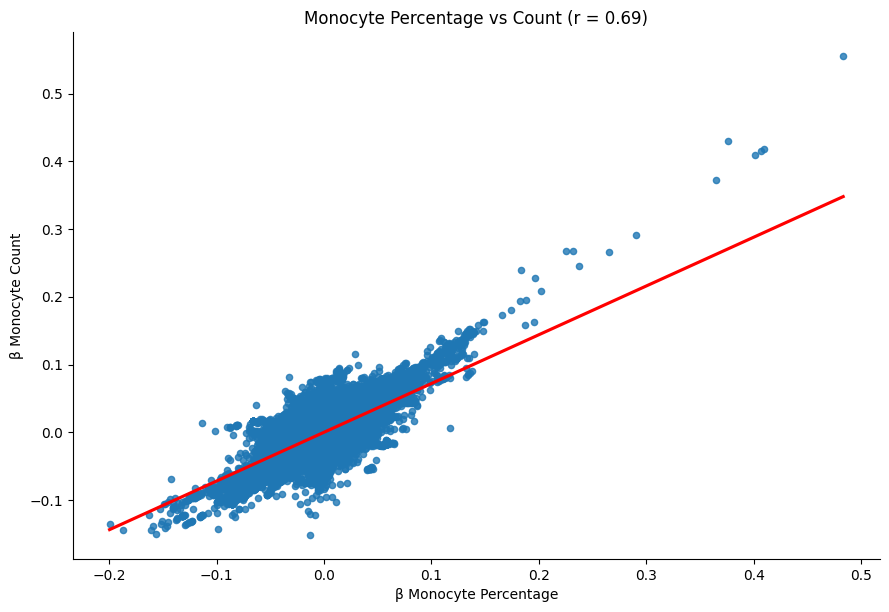

In [6]:
def scatter_plot_with_lm(summ_stats, trait1, trait2):
    # Extract the data for the two traits
    data1 = summ_stats[trait1][['variant', 'beta']]
    data2 = summ_stats[trait2][['variant', 'beta']]

    # Merge the two datasets on the 'variant' column
    merged_data = pd.merge(data1, data2, on='variant', how='inner', suffixes=(f"_{trait1}", f"_{trait2}"))

    # Check the alignment of variants
    print(f"Aligned variants: {len(merged_data)}")

    # Create scatter plot with linear regression line
    sns.lmplot(x=f'beta_{trait1}',
               y=f'beta_{trait2}',
               data=merged_data,
               aspect=1.5,
               height=6, 
               scatter_kws={'s': 20},
               line_kws={'color': 'red'})
    
    # Add R^2 value in the plot title
    r = merged_data[f'beta_{trait1}'].corr(merged_data[f'beta_{trait2}'])
    plt.title(f"Monocyte Percentage vs Count (r = {r:.2f})")
    plt.xlabel(f"β Monocyte Percentage")
    plt.ylabel(f"β Monocyte Count")
    plt.show()

trait1 = "mono_p"
trait2 = "mono_c"
scatter_plot_with_lm(summ_stats, trait1, trait2)


### 1.4 Write files

In [45]:
# Prepare snploc and SNP P-value file data
all_pval_data = {}
all_snploc_data = {}

for trait, data in summ_stats.items():
    # Ensure correct types
    data["bp"] = data["bp"].astype("Int64")
    data["chromosome"] = data["chromosome"].astype("Int64")
    
    # Get all SNP ids, chromosome ids and SNP chromosome locations
    all_snploc_data[trait] = data[["variant", "chromosome", "bp"]]

    # SNP id and p-values
    all_pval_data[trait] = data[["variant", "p"]]

    # Subset positive/negative effect SNPs
    pos_effect_data = data[data["beta"] > 0]  
    neg_effect_data = data[data["beta"] < 0]  

    # Add positve effect size data
    all_snploc_data["P-" + trait] = pos_effect_data[["variant", "chromosome", "bp"]]
    all_pval_data["P-" + trait] = pos_effect_data[["variant", "p"]]
    
    # Add negative effect size data
    all_snploc_data["N-" + trait] = neg_effect_data[["variant", "chromosome", "bp"]]
    all_pval_data["N-" + trait] = neg_effect_data[["variant", "p"]]

print(all_snploc_data.keys())

dict_keys(['mono_p', 'P-mono_p', 'N-mono_p', 'mono_c', 'P-mono_c', 'N-mono_c'])


In [46]:
# Writing files for MAGMA
for trait, snploc_data in all_snploc_data.items():
    snploc_file = MAGMA_DIR / "snp_locations" / f"{trait}_SNPLOC.tsv"
    pval_file = MAGMA_DIR / "pvals" / f"{trait}_PVAL.txt"

    # SNP location data file
    snploc_data.to_csv(snploc_file, sep="\t", index=False, header=False)
    # SNP P-values file
    all_pval_data[trait].to_csv(pval_file, sep="\t", index=False, header=True)

    print(f"SNP location file written to: {snploc_file}")
    print(f"PVAL file written to: {pval_file}")

SNP location file written to: ../Data/MAGMA/snp_locations/mono_p_SNPLOC.tsv
PVAL file written to: ../Data/MAGMA/pvals/mono_p_PVAL.txt
SNP location file written to: ../Data/MAGMA/snp_locations/P-mono_p_SNPLOC.tsv
PVAL file written to: ../Data/MAGMA/pvals/P-mono_p_PVAL.txt
SNP location file written to: ../Data/MAGMA/snp_locations/N-mono_p_SNPLOC.tsv
PVAL file written to: ../Data/MAGMA/pvals/N-mono_p_PVAL.txt
SNP location file written to: ../Data/MAGMA/snp_locations/mono_c_SNPLOC.tsv
PVAL file written to: ../Data/MAGMA/pvals/mono_c_PVAL.txt
SNP location file written to: ../Data/MAGMA/snp_locations/P-mono_c_SNPLOC.tsv
PVAL file written to: ../Data/MAGMA/pvals/P-mono_c_PVAL.txt
SNP location file written to: ../Data/MAGMA/snp_locations/N-mono_c_SNPLOC.tsv
PVAL file written to: ../Data/MAGMA/pvals/N-mono_c_PVAL.txt


Processing gene location file to MAGMA format.<br>
The gene location file must contain at least four columns, in this order: (1) **gene ID**, (2) **chromosome**, (3) **start site**, (4) **stop site**.<br> 

#### <b>Formatting GRCh38 gene location file

In [51]:
gene_location_file = Path("../Data/Reference/GRCh38/LimixAnnotationFile.txt")
gene_loc_data = pd.read_csv(gene_location_file, sep="\t")
print(gene_loc_data.head())

    feature_id chromosome  start     end             ENSG         biotype
0  MIR1302-2HG          1  29554   31109  ENSG00000243485         lincRNA
1      FAM138A          1  34554   36081  ENSG00000237613         lincRNA
2        OR4F5          1  65419   71585  ENSG00000186092  protein_coding
3   AL627309.1          1  89295  133723  ENSG00000238009         lincRNA
4   AL627309.3          1  89551   91105  ENSG00000239945         lincRNA


In [67]:
print(gene_loc_data["chromosome"].unique())

['1' '2' '3' '4' '5' '6' '7' 'X' '8' '9' '11' '10' '12' '13' '14' '15'
 '16' '17' '18' '20' '19' 'Y' '22' '21' 'MT']


In [57]:
# Format and writ to file
file_loc = MAGMA_DIR / "gene_locations" / "GRCh38_GENELOC.tsv"
gene_loc_data[ [ "feature_id", "chromosome", "start", "end"] ].to_csv(file_loc, sep="\t", header=None, index=None)
print(f"File written to {file_loc}")

File written to ../Data/MAGMA/gene_locations/GRCh38_GENELOC.tsv


#### <b>2.1 LiftOver approach (Discarded)

In [14]:
DATA_ANNOT = Path("../Data/Reference/GRCh38/LimixAnnotationFile.txt")
chain_file = "../Data/Reference/GRCh37/hg38ToHg19.over.chain.gz"

# Load gene
gene_anno_data = pd.read_csv(DATA_ANNOT, sep="\t")
print(gene_anno_data.head())

# Initialize LiftOver object with the GRCh38 to GRCh37 chain file
lo = LiftOver(chain_file)

coordinates = list(zip(gene_anno_data['chromosome'], gene_anno_data['start'], gene_anno_data['end'], gene_anno_data['feature_id']))

    feature_id chromosome  start     end             ENSG         biotype
0  MIR1302-2HG          1  29554   31109  ENSG00000243485         lincRNA
1      FAM138A          1  34554   36081  ENSG00000237613         lincRNA
2        OR4F5          1  65419   71585  ENSG00000186092  protein_coding
3   AL627309.1          1  89295  133723  ENSG00000238009         lincRNA
4   AL627309.3          1  89551   91105  ENSG00000239945         lincRNA


In [16]:
# Write file for online liftover tool
bed_df = gene_anno_data[['chromosome', 'start', 'end', 'feature_id']].copy()
# Change to correct gene names
bed_df['chromosome'] = bed_df['chromosome'].apply(lambda x: 'chrM' if x == 'MT' else f'chr{x}')
bed_df.to_csv('../Data/Reference/GRCh37/hg38ToHg19_anno.bed', sep='\t', index=False, header=False)

In [28]:
# Failure genes produced by UCSC LiftOver website tool
bad_map_file = "../Data/Reference/GRCh37/hg38ToHg19_failure.bed"
bad_map_data = pd.read_csv(bad_map_file, sep="\t", comment="#", header=None)

lost_genes = list(bad_map_data[3])
print(f'n lost genes: {len(lost_genes)} \n{lost_genes}')

n lost genes: 198 
['CDK11B', 'TTC34', 'PRAMEF27', 'HNRNPCL3', 'PRAMEF25', 'PRAMEF26', 'HNRNPCL4', 'PRAMEF9', 'PRAMEF13', 'CROCC', 'SEC22B', 'NBPF26', 'PPIAL4A', 'LINC00623', 'FCGR1B', 'AC244453.3', 'AC244453.2', 'AC244453.1', 'SRGAP2C', 'AC245595.1', 'LINC01632', 'FP700111.1', 'SRGAP2B', 'PPIAL4D', 'AC245014.3', 'AC245014.1', 'NBPF20', 'NBPF10', 'AC239799.1', 'AC243756.1', 'PPIAL4G', 'NBPF14', 'NBPF9', 'AC245297.3', 'NBPF19', 'PPIAL4C', 'MUC1', 'RAB7B', 'SRGAP2', 'CAPN8', 'LINC01348', 'LYPD8', 'LINC01115', 'IGKJ2', 'AL845331.2', 'TWIST2', 'SHISA5', 'DNAH12', 'SLC25A26', 'ZNF718', 'AC017091.1', 'AC239584.1', 'DUX4', 'AC142391.1', 'ECSCR', 'PRIM2', 'FO680682.1', 'CD24', 'FAM20C', 'IKZF1', 'AC237221.1', 'MUC3A', 'AC254629.1', 'SH2B2', 'COPG2', 'TRBV6-2', 'TRBV7-2', 'TRBV7-3', 'TRBV7-9', 'TRBV13', 'TRBV10-3', 'TRBV11-3', 'TRBV12-3', 'TRBV12-4', 'TRBV12-5', 'TRBV14', 'TRBV15', 'TRBV16', 'TRBV17', 'TRBV18', 'PRSS2', 'TRBD1', 'TRBJ1-1', 'TRBJ1-2', 'TRBJ1-3', 'TRBJ1-4', 'TRBJ1-5', 'TRBJ1-6', 

In [5]:
# Writing to correct format for MAGMA gene locations file
geneloc_dir = MAGMA_DIR / "gene_locations"
lifted_anno_file = "../Data/Reference/GRCh37/hg38ToHg19_lifted.bed"

lifted_data = pd.read_csv(lifted_anno_file, sep="\t", comment="#", header=None, names=["Chromosome", "Start", "End", "gene_name"])
lifted_data["Chromosome"] = lifted_data["Chromosome"].str.replace("chr", "", regex=False)
lifted_data[ [ "gene_name", "Chromosome", "Start", "End"] ].to_csv(geneloc_dir / "hg38ToHg19_lifted.tsv", sep="\t", header=None, index=None)


In [ ]:
### DISCARDED METHOD ####

bad_maps = []
errors = {}

# Perform liftOver conversion from GRCh38 to GRCh37
for idx, (chromosome, start, end, gene_name) in enumerate(coordinates):
    try:           
        chrom = "chr" + chromosome
        hg19_start = lo.convert_coordinate(chrom, start)
        hg19_end = lo.convert_coordinate(chrom, end)
        
        
        if (hg19_start[0][2] != hg19_end[0][2]):
            print(f' BAD gene name:{gene_name} chr {chrom} start {start}, end {end}')
            bad_maps.append(gene_name)
        
        if (chrom != hg19_start[0][0]) or (chrom != hg19_end[0][0]) or (hg19_start[0][0] != hg19_end[0][0]):
            bad_maps.append(gene_name)

        if idx % 200 == 0:
            print(f'GOOD chr {chrom} start {start}, end {end} name {gene_name}')
            
    except Exception as e:
        error_msg = str(e)  # Convert exception to string
        if error_msg not in errors:
            errors[error_msg] = 1
        else:
            errors[error_msg] += 1
        bad_maps.append(gene_name)
        
# # Add converted coordinates to DataFrame
# df['converted_start'] = [coord[0] if coord else None for coord in converted_coordinates]
# df['converted_end'] = [coord[1] if coord else None for coord in converted_coordinates]
print(errors.items())
print(f'N bad genes: {len(bad_maps)}')
print(bad_maps)
# Output the converted data (GRCh37 coordinates)
# print(grch37_data)


#### <b>2.2 pyensemble gene_by_id approach (Discarded)

In [ ]:
# DEPRECATED

# Load the GRCh37 (hg19) Ensembl annotation
ensembl_grch37 = pyensembl.EnsemblRelease(75)  # GRCh37/hg19 final release

# Example Ensembl Gene IDs from GRCh38
gene_ids = ["ENSG00000223972", "ENSG00000139618"]  # Example: BRAF, BRCA2

# Get gene locations in GRCh37
for gene_id in gene_ids:
    # try:
        gene = ensembl_grch37.genes_by_name("MIR1302-2HG")
        # gene = ensembl_grch37.gene_by_id(gene_id)
        print(f"{gene_id} -> {gene.contig}:{gene.start}-{gene.end} ({gene.strand})")
    # except ValueError:
        # print(f"{gene_id} not found in GRCh37")

#### <b>2.3 Mapping ensemble ids approach (Discarded)

In [25]:
# DEPERECATED

GENLOC_REFERENCE = Path("../Data/Reference/GRCh37/gencode.v19.annotation.gtf")
# GENLOC_REFERENCE = Path("../Data/Reference/GRCh37/Homo_sapiens.GRCh37.87.chr.gtf")

# Read .gtf file
gtf_data = pd.read_csv(GENLOC_REFERENCE, sep="\t", skiprows=5, header=None)
gtf_data.columns = ["chromosome", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]

print(gtf_data.head())

  chromosome  source     feature  start    end score strand frame  \
0       chr1  HAVANA        gene  11869  14412     .      +     .   
1       chr1  HAVANA  transcript  11869  14409     .      +     .   
2       chr1  HAVANA        exon  11869  12227     .      +     .   
3       chr1  HAVANA        exon  12613  12721     .      +     .   
4       chr1  HAVANA        exon  13221  14409     .      +     .   

                                           attribute  
0  gene_id "ENSG00000223972.4"; transcript_id "EN...  
1  gene_id "ENSG00000223972.4"; transcript_id "EN...  
2  gene_id "ENSG00000223972.4"; transcript_id "EN...  
3  gene_id "ENSG00000223972.4"; transcript_id "EN...  
4  gene_id "ENSG00000223972.4"; transcript_id "EN...  


In [ ]:
# Subset genes data, remove chromosome Y data to avoid duplicate gene names
gtf_genes = gtf_data[(gtf_data["feature"] == "gene") & (gtf_data["seqname"] != "chrY")].copy()

# Extract ENSEMBL id
gtf_genes["ENSG"] = gtf_genes["attribute"].str.extract(r'gene_id "([^"]+)"').copy()
gtf_genes["ENSG"] = gtf_genes["ENSG"].str.split(".").str[0]

gtf_genes["feature_id"] = gtf_genes["attribute"].str.extract(r'gene_name "([^"]+)"').copy()

# Keep relevant columns
gtf_genes = gtf_genes[["chromosome", "start", "end", "strand", "ENSG", "feature_id"]]

print(gtf_genes.head())

In [296]:

# Ensure gene_id in gtf_genes matches format
gtf_genes["gene_id"] = gtf_genes["gene_id"].str.split(".").str[0]


if not gtf_genes.gene_id.is_unique:
    print("Duplicate gen ids!")
    dup_ids = gtf_genes[gtf_genes.duplicated(subset="gene_id", keep=False)]
    print(dup_ids[["gene_id"]])

C:\Users\hesse\AppData\Local\Temp\ipykernel_32548\1253071934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_genes["gene_id"] = gtf_genes["gene_id"].str.split(".").str[0]


In [297]:
# Merge 
gtf_genes = gtf_genes.merge(gene_anno_file[["gene_id", "gene_name"]], on="gene_id", how="inner", suffixes=("", "_b"))
gtf_genes["gene_name"] = gtf_genes["gene_name_b"].combine_first(gtf_genes["gene_name"])
gtf_genes.drop(columns=["gene_name_b"], inplace=True)

gtf_genes.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,29553,31109,.,+,.,ENSG00000243485,lncRNA,...,NaN,NaN,NaN,ncRNA_host,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,gene,65418,71585,.,+,.,ENSG00000186092,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,gene,160445,161525,.,+,.,ENSG00000241599,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,HAVANA,gene,358856,366052,.,+,.,ENSG00000236601,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,HAVANA,gene,587628,594768,.,+,.,ENSG00000235146,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking duplicate genes

In [298]:
dup_genes = gtf_genes[gtf_genes.duplicated(subset="gene_name", keep=False)]
print(dup_genes[["gene_name", "gene_id"]])

Empty DataFrame
Columns: [gene_name, gene_id]
Index: []


In [302]:
print(f"Non-mapped genes: {len(gene_anno_file) - len(gtf_genes)}")

Non-mapped genes: 379


In [307]:
# MAGMA does not accept chrX format
gtf_genes["Chromosome"] = gtf_genes["Chromosome"].str.replace("chr", "", regex=False)

Mapping in this manner loses 379 genes. This is not ideal, but maybe expected since this reference file is based on build 37, while the annotation file is based on build 38.

In [308]:
# Format and writ to file
gtf_genes[ [ "gene_name", "Chromosome", "Start", "End", "Strand"] ].to_csv(MAGMA_DIR / "GRCh37_GENELOC.tsv", sep="\t", header=None, index=None)

# <b>3. MAGMA

In [4]:
TRAITS = [
    "mono_p",
    "mono_c",
    "P-mono_c",
    "P-mono_p",
    "N-mono_p",
    "N-mono_c",
]
geneloc_file = MAGMA_DIR / "gene_locations" / "GRCh38_GENELOC.tsv"
window = "5,5"

### Gene window analysis

In [64]:
window_sizes = ["0,0", "5,5", "10,10"]

for snploc_file, trait in iterate_trait_files(MAGMA_DIR / "snp_locations", TRAITS):
    annotation_results = run_window_analysis(
        snploc_file=snploc_file,
        geneloc_file=geneloc_file,
        window_sizes=window_sizes
    )
    
    display(annotation_results.style.set_caption(f"Annotation results for {trait}"))
    print("=" * 60)

Running analysis for ../Data/MAGMA/snp_locations/mono_p_SNPLOC.tsv


,Window size,Mapped SNPs,Mapped genes (total genes)
0,"0,0","4,878,836 (52.63%)","30,876 (33,461)"
1,"5,5","5,419,908 (58.47%)","31,877 (33,461)"
2,"10,10","5,815,727 (62.74%)","31,951 (33,461)"


Running analysis for ../Data/MAGMA/snp_locations/mono_c_SNPLOC.tsv


,Window size,Mapped SNPs,Mapped genes (total genes)
0,"0,0","4,672,781 (52.54%)","30,855 (33,461)"
1,"5,5","5,190,414 (58.36%)","31,882 (33,461)"
2,"10,10","5,569,525 (62.63%)","31,958 (33,461)"


Running analysis for ../Data/MAGMA/snp_locations/P-mono_c_SNPLOC.tsv


,Window size,Mapped SNPs,Mapped genes (total genes)
0,"0,0","2,322,945 (52.45%)","29,436 (33,461)"
1,"5,5","2,580,791 (58.27%)","31,775 (33,461)"
2,"10,10","2,769,763 (62.54%)","31,883 (33,461)"


Running analysis for ../Data/MAGMA/snp_locations/P-mono_p_SNPLOC.tsv


,Window size,Mapped SNPs,Mapped genes (total genes)
0,"0,0","2,425,117 (52.62%)","29,547 (33,461)"
1,"5,5","2,691,913 (58.41%)","31,797 (33,461)"
2,"10,10","2,888,139 (62.66%)","31,891 (33,461)"


### Create gene annotation file

In [9]:
out_dir = MAGMA_DIR / "gene_annotations" / (window + "_window") 
out_dir.mkdir(parents=True, exist_ok=True)

for snploc_file, trait in iterate_trait_files(MAGMA_DIR / "snp_locations", TRAITS):
    out_file = out_dir / trait

    print(f"Processing trait: {trait}...")
    result = run_gene_annotation(window = window, 
                                snploc_file = snploc_file,
                                geneloc_file = geneloc_file, 
                                out_file = out_file)
    print(result)
    print("=" * 90)
print("Done")

Processing trait: mono_p...
Welcome to MAGMA v1.10 (linux/s)
Using flags:
	--annotate window=5,5
	--snp-loc ../Data/MAGMA/snp_locations/mono_p_SNPLOC.tsv
	--gene-loc ../Data/MAGMA/gene_locations/GRCh38_GENELOC.tsv
	--out ../Data/MAGMA/gene_annotations/5,5window/mono_p

Start time is 12:31:43, Wednesday 19 Mar 2025

Starting annotation...
Reading gene locations from file ../Data/MAGMA/gene_locations/GRCh38_GENELOC.tsv... 
	adding window: 5000bp
	33461 gene locations read from file
	chromosome  1: 3150 genes
	chromosome  2: 2281 genes
	chromosome  3: 1709 genes
	chromosome  4: 1353 genes
	chromosome  5: 1659 genes
	chromosome  6: 1630 genes
	chromosome  7: 1535 genes
	chromosome  8: 1318 genes
	chromosome  9: 1226 genes
	chromosome 10: 1228 genes
	chromosome 11: 1919 genes
	chromosome 12: 1761 genes
	chromosome 13: 666 genes
	chromosome 14: 1385 genes
	chromosome 15: 1133 genes
	chromosome 16: 1529 genes
	chromosome 17: 1894 genes
	chromosome 18: 662 genes
	chromosome 19: 2004 genes
	chr

### Run batch gene analysis

In [7]:
samples = "N=563085" 
n_batches = 10
out_dir = MAGMA_DIR / "gene_analysis" / (window + "_window")
ld_reference = Path("/groups/umcg-franke-scrna/tmp02/external_datasets/hg38/ref_panel_QC/30x-GRCh38-EUR")

for trait in TRAITS:
    gene_anno_file = MAGMA_DIR / "gene_annotations" / (window + "_window") / f"{trait}.genes.annot"
    pval_file = MAGMA_DIR / "pvals" / f"{trait}_PVAL.txt"
    batch_gene_analysis(
        trait = trait, 
        samples = samples, 
        n_batches = n_batches, 
        gene_anno_file = gene_anno_file,
        pval_file = pval_file,
        out_dir = out_dir,
        reference = ld_reference,
        mem = "3gb"
    )
    

Submitted batch 1: Submitted batch job 1214868
Submitted batch 2: Submitted batch job 1214869
Submitted batch 3: Submitted batch job 1214870
Submitted batch 4: Submitted batch job 1214871
Submitted batch 5: Submitted batch job 1214872
Submitted batch 6: Submitted batch job 1214873
Submitted batch 7: Submitted batch job 1214874
Submitted batch 8: Submitted batch job 1214875
Submitted batch 9: Submitted batch job 1214876
Submitted batch 10: Submitted batch job 1214877
Submitted batch 1: Submitted batch job 1214878
Submitted batch 2: Submitted batch job 1214879
Submitted batch 3: Submitted batch job 1214880
Submitted batch 4: Submitted batch job 1214881
Submitted batch 5: Submitted batch job 1214882
Submitted batch 6: Submitted batch job 1214883
Submitted batch 7: Submitted batch job 1214884
Submitted batch 8: Submitted batch job 1214885
Submitted batch 9: Submitted batch job 1214886
Submitted batch 10: Submitted batch job 1214887
Submitted batch 1: Submitted batch job 1214888
Submitted b

### Gene analysis results 

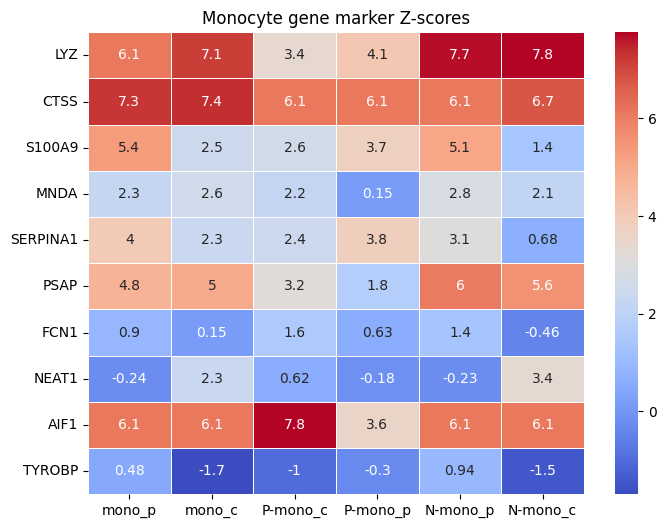

In [5]:
# Initialize variables
trait_gene_data = {}
found_markers = {}  # For tracking marker genes for each trait
n_genes = 1000

all_marker_data = {}

# Read Gene Analysis results and store gene scores
for trait in TRAITS:
    results_dir = MAGMA_DIR / "gene_analysis" / (window + "_window") / trait
    found_markers[trait] = []  # Initialize an empty list for each trait's found markers
    for file in results_dir.iterdir():
        if file.name.endswith("genes.out"):
            with open(file, "r") as f:
                f.readline()  # skip header
                for line in f:
                    line = line.split()
                    z_score = float(line[7])  
                    gene_name = line[0]
                    
                    # Store data for the trait
                    if trait not in trait_gene_data:
                        trait_gene_data[trait] = [[gene_name, z_score]]
                    else:
                        trait_gene_data[trait].append([gene_name, z_score])

                    # Check if gene is a monocyte marker gene
                    if gene_name in mono_marker_genes:
                        if gene_name not in all_marker_data.keys():
                            all_marker_data[gene_name] = {trait: z_score}
                        else:
                            all_marker_data[gene_name][trait] = z_score

# Convert the all_marker_data dictionary to a pandas DataFrame
marker_df = pd.DataFrame.from_dict(all_marker_data, orient="index")

if not marker_df.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(marker_df, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Monocyte gene marker Z-scores")
    plt.show()
else:
    print("No marker genes found.")

In [6]:
# Get the top n genes based on their Z-scores for each trait
top_genes_per_trait = {}
for trait, genes in trait_gene_data.items():
    top_1000_for_trait = heapq.nlargest(n_genes, genes, key=lambda x: x[1])
    top_genes_per_trait[trait] = top_1000_for_trait

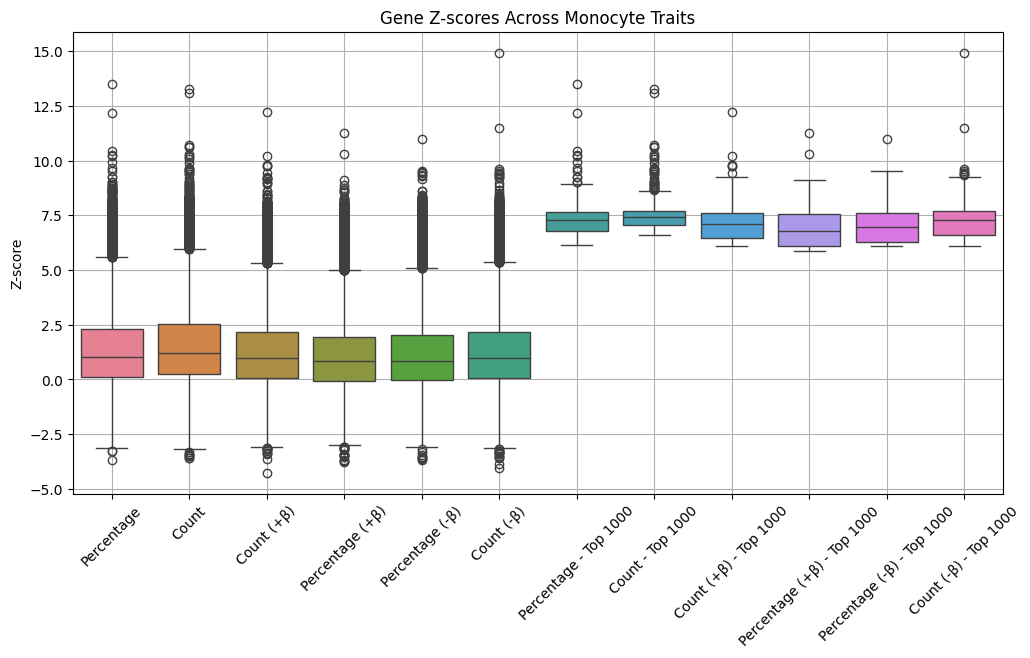

In [15]:
# Create boxplot data
boxplot_data = []
label_map = {
    "mono_p"   : "Percentage",
    "mono_c"   : "Count",
    "P-mono_p" : "Percentage (+β)",
    "P-mono_c" : "Count (+β)",
    "N-mono_c" : "Count (-β)",
    "N-mono_p" : "Percentage (-β)",
}

labels = []

# Add data for all genes' Z-scores
for trait, genes in trait_gene_data.items():
    z_scores_for_trait = [z_score for _, z_score in genes]  # Get Z-scores for all genes
    
    boxplot_data.append(z_scores_for_trait)  # Add all gene Z-scores
    labels.append(label_map[trait])  # Label for all genes

# Add data for top 1000 genes' Z-scores
for trait, top_genes in top_genes_per_trait.items():
    z_scores_for_trait = [z_score for _, z_score in top_genes]  # Get Z-scores for top 1000 genes
    
    boxplot_data.append(z_scores_for_trait)  # Add top 1000 gene Z-scores
    labels.append(f"{label_map[trait]} - Top {n_genes}")  # Label for top 1000 genes

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_data)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylabel("Z-score")
plt.title(f"Gene Z-scores Across Monocyte Traits")
plt.grid(True)

plt.show()

## scDRS geneset file

In [12]:
gene_set_data = {}
for trait, top_genes_data in top_genes_per_trait.items():
    n_genes = len(top_genes_data)
    for gene_name, z_score in top_genes_data:
        gene_score = f"{gene_name}:{z_score}"                
        if trait not in gene_set_data:
            gene_set_data[trait] = gene_score
        else:
            gene_set_data[trait] += "," + gene_score

gene_set_file = SCDRS_DIR / "genesets" / f"N{n_genes}_{'-'.join(gene_set_data.keys())}_W{window}.gs"
pd.DataFrame(list(gene_set_data.items()), columns=["TRAIT", "GENESET"]).to_csv(gene_set_file, sep="\t", index=False)
print(f"Geneset written to {gene_set_file}")

Geneset written to ../Data/SCDRS/genesets/N1000_mono_p-mono_c-P-mono_c-P-mono_p-N-mono_p-N-mono_c_W5,5.gs


### Generating control geneset tests with various configurations:
1. monocyte markers set to a very high (30) Z-score, and all other genes low Z-score.
2. monocyte markers set to a very high (30) Z-score, and all other genes the same.
3. All monocyte markers set to a very high (30) Z-score and added to the geneset.
      

In [8]:
# Initialize dictionaries to store different control genesets
window = "5,5"
control_gs_data_1 = {}  # Markers high (30), all others low (0.1)
control_gs_data_2 = {}  # Markers high (30), all others unchanged
control_gs_data_3 = {}  # Markers high (30), added if missing

for trait, top_genes_data in top_genes_per_trait.items():
    # Initialize empty strings for each geneset
    control_gs_data_1[trait] = ""
    control_gs_data_2[trait] = ""
    control_gs_data_3[trait] = ",".join([f"{gene}:30" for gene in mono_marker_genes])

    for gene_name, z_score in top_genes_data:
        # Configuration 1: Markers high (30), all others low (0.1)
        if gene_name in mono_marker_genes:
            gs_1_score = f"{gene_name}:30"
        else:
            gs_1_score = f"{gene_name}:0.1"

        if control_gs_data_1[trait]:
            control_gs_data_1[trait] += ","
        control_gs_data_1[trait] += gs_1_score

        # Configuration 2: Markers high (30), all others unchanged
        if gene_name in mono_marker_genes:
            gs_2_score = f"{gene_name}:30"
        else:
            gs_2_score = f"{gene_name}:{z_score}"

        if control_gs_data_2[trait]:
            control_gs_data_2[trait] += ","
        control_gs_data_2[trait] += gs_2_score

        # Configuration 3: Markers high (30), added if missing
        if not gene_name in mono_marker_genes:
            gs_3_score = f",{gene_name}:{z_score}"
            control_gs_data_3[trait] += gs_3_score

for i, gs_data in enumerate([control_gs_data_1, control_gs_data_2, control_gs_data_3], start=1):
    gs_file = SCDRS_DIR / "genesets" / f"GS_control_{i}_{"-".join(top_genes_per_trait.keys())}_{window}.gs"
    pd.DataFrame(list(gs_data.items()), columns=["TRAIT", "GENESET"]).to_csv(gs_file, sep="\t", index=False)
    print(f"Geneset {i} written to {gs_file}")

CTSS:30,FCN1:30,NEAT1:30,LYZ:30,PSAP:30,S100A9:30,AIF1:30,MNDA:30,SERPINA1:30,TYROBP:30
CTSS:30,FCN1:30,NEAT1:30,LYZ:30,PSAP:30,S100A9:30,AIF1:30,MNDA:30,SERPINA1:30,TYROBP:30
Geneset 1 written to ../Data/SCDRS/genesets/GS_control_1_mono_p-mono_c_5,5.gs
Geneset 2 written to ../Data/SCDRS/genesets/GS_control_2_mono_p-mono_c_5,5.gs
Geneset 3 written to ../Data/SCDRS/genesets/GS_control_3_mono_p-mono_c_5,5.gs


### Control Gene Sets with Differentially Expressed Genes (DEGs) Derived from Empirical Data

In [6]:
monocyte_degs = ['PLXDC2', 'ZEB2', 'NEAT1', 'ARHGAP26', 'FAM49A', 'IRAK3', 'LYN', 'KYNU', 'SAT1', 'LRMDA']

# Initialize dictionaries to store different control genesets
control_gs_data_1 = {}  # Markers high (30), all others low (0.1)
control_gs_data_2 = {}  # Markers high (30), all others unchanged
control_gs_data_3 = {}  # Markers high (30), added if missing

for trait, top_genes_data in top_genes_per_trait.items():
    # Initialize empty strings for each geneset
    control_gs_data_1[trait] = ""
    control_gs_data_2[trait] = ""
    control_gs_data_3[trait] = ",".join([f"{gene}:30" for gene in monocyte_degs])

    for gene_name, z_score in top_genes_data:
        # Configuration 1: Markers high (30), all others low (0.1)
        if gene_name in monocyte_degs:
            gs_1_score = f"{gene_name}:30"
        else:
            gs_1_score = f"{gene_name}:0.1"

        if control_gs_data_1[trait]:
            control_gs_data_1[trait] += ","
        control_gs_data_1[trait] += gs_1_score

        # Configuration 2: Markers high (30), all others unchanged
        if gene_name in monocyte_degs:
            gs_2_score = f"{gene_name}:30"
        else:
            gs_2_score = f"{gene_name}:{z_score}"

        if control_gs_data_2[trait]:
            control_gs_data_2[trait] += ","
        control_gs_data_2[trait] += gs_2_score

        # Configuration 3: Markers high (30), added if missing
        if not gene_name in monocyte_degs:
            gs_3_score = f",{gene_name}:{z_score}"
            control_gs_data_3[trait] += gs_3_score

for i, gs_data in enumerate([control_gs_data_1, control_gs_data_2, control_gs_data_3], start=1):
    gs_file = SCDRS_DIR / "genesets" / f"DEGS_control_{i}_{"-".join(top_genes_per_trait.keys())}_{window}.gs"
    pd.DataFrame(list(gs_data.items()), columns=["TRAIT", "GENESET"]).to_csv(gs_file, sep="\t", index=False)
    print(f"Geneset {i} written to {gs_file}")


Geneset 1 written to ../Data/SCDRS/genesets/DEGS_control_1_mono_p-mono_c_5,5.gs
Geneset 2 written to ../Data/SCDRS/genesets/DEGS_control_2_mono_p-mono_c_5,5.gs
Geneset 3 written to ../Data/SCDRS/genesets/DEGS_control_3_mono_p-mono_c_5,5.gs
